# Plant Leaf Disease Classification

In [ ]:
import torch 
import torchvision
import torchvision.transforms as transforms 
import numpy as np 
from torchvision.datasets import ImageFolder
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, TensorDataset
from PIL import Image
from matplotlib import pyplot as plt
from matplotlib import cm
import pandas as pd
import os
from torchvision import datasets, models, transforms
import time
import copy
from torch.optim.lr_scheduler import ReduceLROnPlateau 
from torch.utils.data.sampler import WeightedRandomSampler

**잎 사진을 통한 질병 분류**

*   데이터: 33개의 클래스로 구분된 약 40000장의 이미지
><img src="https://drive.google.com/uc?id=1YQkxnNy61Gyi3Gp6ylCKeS72BVruJXr_" width="700" height="500"> 
*   데이터 전처리
    *   전체 데이터를 6:2:2의 비율로 train,validation,test로 나눔
    *   augmentation을 통한 클래스 별 불균형 해소
    
*   학습 진행 방향
    *   Baseline 모델(pre-trained model 사용X) 구축
    *   Pre-trained 모델 사용: Resnet50
    1.   Baseline 모델 비교: split된 원본 데이터 사용, oversampling된 데이터 사용
    2.   Pre-trained 모델 비교: Baseline,ResNet50 성능 비교

In [ ]:
# gdrive에 mount
from google.colab import drive
drive.mount('/content/gdrive')
# 경로 설정
import os
os.chdir('/content/gdrive/My Drive/')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## **데이터 전처리**

### Split raw data → 6:2:2

In [ ]:
import os, shutil

# 원본 데이터 경로
original_dataset_dir = '/content/gdrive/My Drive/Plant_leaf_sample'

# 클래스 list
classes_list = os.listdir(original_dataset_dir)

# split한 데이터를 저장할 디렉토리 지정 후 생성
base_dir = '/content/gdrive/My Drive/plant_leaf/dataset_split_raw'
os.mkdir(base_dir)

# train/validation/test 하위 폴더 생성
train_dir = os.path.join(base_dir, 'train')
os.mkdir(train_dir)
validation_dir = os.path.join(base_dir, 'val')
os.mkdir(validation_dir)
test_dir = os.path.join(base_dir, 'test')
os.mkdir(test_dir)


for cls in classes_list:
    # train 하위 폴더로 클래스 별 폴더 생성
    os.mkdir(os.path.join(train_dir, cls))
    
    # validation 하위 폴더로 클래스 별 폴더 생성
    os.mkdir(os.path.join(validation_dir, cls))
    
    # test 하위 폴더로 클래스 별 폴더 생성
    os.mkdir(os.path.join(test_dir, cls))

In [ ]:
import math

for cls in classes_list:
    path = os.path.join(original_dataset_dir, cls)
    fnames = os.listdir(path)
    # 데이터 나눌 비율 지정 (6:2:2)
    train_size = math.floor(len(fnames) * 0.6)
    validation_size = math.floor(len(fnames) * 0.2)
    test_size = math.floor(len(fnames) * 0.2)
    
    train_fnames = fnames[:train_size]
    print("Train size(",cls,"): ", len(train_fnames))
    for fname in train_fnames:
        src = os.path.join(path, fname)
        dst = os.path.join(os.path.join(train_dir, cls), fname)
        shutil.copyfile(src, dst)
        
    validation_fnames = fnames[train_size:(validation_size + train_size)]
    print("Validation size(",cls,"): ", len(validation_fnames))
    for fname in validation_fnames:
        src = os.path.join(path, fname)
        dst = os.path.join(os.path.join(validation_dir, cls), fname)
        shutil.copyfile(src, dst)
        
    test_fnames = fnames[(train_size+validation_size):(validation_size + train_size +test_size)]
    print("Test size(",cls,"): ", len(test_fnames))
    for fname in test_fnames:
        src = os.path.join(path, fname)
        dst = os.path.join(os.path.join(test_dir, cls), fname)
        shutil.copyfile(src, dst)

Train size( Tomato___Target_Spot ):  75
Validation size( Tomato___Target_Spot ):  25
Test size( Tomato___Target_Spot ):  25
Train size( Tomato___Leaf_Mold ):  58
Validation size( Tomato___Leaf_Mold ):  19
Test size( Tomato___Leaf_Mold ):  19
Train size( Tomato___Septoria_leaf_spot ):  75
Validation size( Tomato___Septoria_leaf_spot ):  25
Test size( Tomato___Septoria_leaf_spot ):  25
Train size( Tomato___healthy ):  67
Validation size( Tomato___healthy ):  22
Test size( Tomato___healthy ):  22
Train size( Tomato___Bacterial_spot ):  50
Validation size( Tomato___Bacterial_spot ):  16
Test size( Tomato___Bacterial_spot ):  16
Train size( Tomato___Late_blight ):  54
Validation size( Tomato___Late_blight ):  18
Test size( Tomato___Late_blight ):  18
Train size( Tomato___Spider_mites Two-spotted_spider_mite ):  63
Validation size( Tomato___Spider_mites Two-spotted_spider_mite ):  21
Test size( Tomato___Spider_mites Two-spotted_spider_mite ):  21
Train size( Tomato___Early_blight ):  54
Vali

random split 진행 후 데이터 수

><img src="https://drive.google.com/uc?id=1e4huPE5W5WCSYSf7P2XDRtyscT1ocOYH" width="400" height="500">

클래스 별 이미지 개수 차이가 크다는 것을 알 수 있다. 데이터 수가 900개 미만인 클래스에 augmentation을 이용하여 오버샘플링을 진행하였다.

### class imbalance 보완

In [ ]:
transform_raw = transforms.Compose([transforms.Resize((64,64),interpolation=Image.NEAREST),transforms.ToTensor() ])
train_imb = ImageFolder(root='/content/gdrive/My Drive/plant_leaf/dataset_split_raw/train', transform=transform_raw)

targets = np.array(train_imb.samples)[:,1]
targets = targets.astype(int)

class_data_count = np.unique(targets, return_counts=True)[1]
print(class_data_count)    #클래스별 이미지 개수


[50 71 71 67 63 63 63 54 54 54 58 54 67 58 54 75 75 63 63 63 58 67 58 50
 54 54 58 75 63 75 54 58 67]


In [ ]:
weight

array([0.02      , 0.01408451, 0.01724138, 0.01851852, 0.01492537,
       0.01724138, 0.01851852, 0.01333333, 0.01333333, 0.01587302,
       0.01587302, 0.01587302, 0.01408451, 0.01724138, 0.01492537,
       0.01724138, 0.02      , 0.01851852, 0.01851852, 0.01724138,
       0.01333333, 0.01587302, 0.01333333, 0.01492537, 0.01851852,
       0.01724138, 0.01492537, 0.01587302, 0.01587302, 0.01587302,
       0.01851852, 0.01851852, 0.01851852])

In [ ]:
weight = 1. / class_data_count
samples_weight = weight[targets]
samples_weight = torch.from_numpy(samples_weight)
sampler = WeightedRandomSampler(samples_weight, len(samples_weight))

In [ ]:
weighted_loader = torch.utils.data.DataLoader(train_imb, batch_size=32, sampler=sampler, num_workers=4)

# oversampling에 따라 각 batch에 클래스 분포가 균등
for batch_idx, (data, target) in enumerate(weighted_loader):
    print('Batch {}, classes {}, count {}'.format(
        batch_idx, *np.unique(target.numpy(), return_counts=True)))

## **Baseline model**

### 1. Baseline with splited raw data (imbalanced)

In [ ]:
transform_raw = transforms.Compose([transforms.Resize((64,64),interpolation=Image.NEAREST),transforms.ToTensor() ])  #0~1로 스케일해서 tensor로 저장
train_dataset = ImageFolder(root='./plant_leaf/dataset_split_raw/train', transform=transform_raw) 
val_dataset = ImageFolder(root='./plant_leaf/dataset_split_raw/val', transform=transform_raw) 
test_dataset = ImageFolder(root='./plant_leaf/dataset_split_raw/test', transform=transform_raw) 

#batch iterator
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True, num_workers=4)

In [ ]:
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
EPOCHS     = 30
BATCH_SIZE = 32

class Net(nn.Module):  
  
  def __init__(self):
    
    super(Net, self).__init__()

    self.conv1 = nn.Conv2d(3, 32, 3, padding=1) 
    self.pool = nn.MaxPool2d(2,2) 
    self.conv2 = nn.Conv2d(32, 64, 3, padding=1)   
    self.conv3 = nn.Conv2d(64, 64, 3, padding=1)

    # 전결합층       
    self.fc1 = nn.Linear(4096, 512) 
    self.fc2 = nn.Linear(512, 33)
    
  def forward(self, x):
    
    # 풀링층
    x=self.conv1(x)   #64*64*32
    x=F.relu(x)
    x=self.pool(x)    #32*32*32
    x = F.dropout(x, p=0.25, training=self.training)

    x=self.conv2(x)
    x=F.relu(x)
    x=self.pool(x)
    x = F.dropout(x, p=0.25, training=self.training)

    x=self.conv3(x)
    x=F.relu(x)
    x=self.pool(x)
    x = F.dropout(x, p=0.25, training=self.training)

    x = x.view(-1, 4096)  
    x = self.fc1(x)
    x = F.relu(x)
    x = F.dropout(x, p=0.5, training=self.training)
    x = self.fc2(x)
        
    return F.log_softmax(x, dim=1)  

  
model = Net().cuda()  
optimizer = optim.Adam(model.parameters(), lr=0.01)
print(model)

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=4096, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=33, bias=True)
)


In [ ]:
loss_hist=[]
acc_hist=[]
def train(model, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(DEVICE), target.to(DEVICE)
        optimizer.zero_grad()
        output = model(data)
        #print("output size:  ", output.size())
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        loss_hist.append(loss)
        if batch_idx % 200 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [ ]:
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            #print("target shape:  ", target.shape)
            output = model(data)
            
            # 배치 오차를 합산
            test_loss += F.cross_entropy(output, target, reduction='sum').item()

            # 가장 높은 값을 가진 인덱스가 예측값
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

In [ ]:
#학습시키는 코드

val_acc_hist=[]
val_loss_hist=[]
train_acc_hist=[]
train_loss_hist=[]
for epoch in range(1, EPOCHS + 1):
    train(model_imb, train_loader, optimizer, epoch)
    val_loss, val_accuracy = evaluate(model, val_loader)
    train_loss, train_accuracy = evaluate(model, train_loader)
    val_loss_hist.append(val_loss)
    val_acc_hist.append(val_accuracy)
    train_loss_hist.append(train_loss)
    train_acc_hist.append(train_accuracy)
    print('[{}] Validation Loss: {:.4f}, Accuracy: {:.2f}%'.format(epoch, val_loss, val_accuracy))

Train Epoch: 1 [0/2031 (0%)]	Loss: 3.506862
[1] Test Loss: 3.4197, Accuracy: 6.41%
Train Epoch: 2 [0/2031 (0%)]	Loss: 3.476799
[2] Test Loss: 3.4169, Accuracy: 6.11%
Train Epoch: 3 [0/2031 (0%)]	Loss: 3.488903
[3] Test Loss: 3.3874, Accuracy: 9.84%
Train Epoch: 4 [0/2031 (0%)]	Loss: 3.409873
[4] Test Loss: 3.3754, Accuracy: 7.30%
Train Epoch: 5 [0/2031 (0%)]	Loss: 3.294499
[5] Test Loss: 3.1906, Accuracy: 11.92%
Train Epoch: 6 [0/2031 (0%)]	Loss: 3.383922
[6] Test Loss: 3.1251, Accuracy: 13.11%
Train Epoch: 7 [0/2031 (0%)]	Loss: 2.990563
[7] Test Loss: 3.0149, Accuracy: 15.50%
Train Epoch: 8 [0/2031 (0%)]	Loss: 2.850621
[8] Test Loss: 2.9469, Accuracy: 16.39%
Train Epoch: 9 [0/2031 (0%)]	Loss: 3.273118
[9] Test Loss: 3.1255, Accuracy: 11.48%
Train Epoch: 10 [0/2031 (0%)]	Loss: 2.829699
[10] Test Loss: 2.7403, Accuracy: 22.35%
Train Epoch: 11 [0/2031 (0%)]	Loss: 2.678026
[11] Test Loss: 2.6805, Accuracy: 25.63%
Train Epoch: 12 [0/2031 (0%)]	Loss: 2.561987
[12] Test Loss: 2.7629, Accurac

In [ ]:
torch.save(model_imb,'imbalanced_baseline.pt')

### 2. Baseline with balanced data

Q. validation에는 oversample 안하는게 맞는거지..?

In [ ]:
# imbalanced raw랑 옵션 똑같게 할거면 이부분 삭제 가능
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=True, num_workers=4)  
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32,shuffle=True, num_workers=4)
model_bal = Net().cuda()

In [ ]:
#학습시키는 코드
val_acc_hist=[]
val_loss_hist=[]
train_acc_hist=[]
train_loss_hist=[]
for epoch in range(1, EPOCHS + 1):
    train(model_bal, weighted_loader, optimizer, epoch)
    val_loss, val_accuracy = evaluate(model, val_loader)
    train_loss, train_accuracy = evaluate(model, train_loader)
    val_loss_hist.append(val_loss)
    val_acc_hist.append(val_accuracy)
    train_loss_hist.append(train_loss)
    train_acc_hist.append(train_accuracy)
    print('[{}] Validation Loss: {:.4f}, Accuracy: {:.2f}%'.format(epoch, val_loss, val_accuracy))

Train Epoch: 1 [0/2031 (0%)]	Loss: 3.501228
[1] Validation Loss: 3.4505, Accuracy: 7.30%
Train Epoch: 2 [0/2031 (0%)]	Loss: 3.459445
[2] Validation Loss: 3.0629, Accuracy: 16.69%
Train Epoch: 3 [0/2031 (0%)]	Loss: 3.044279
[3] Validation Loss: 2.6951, Accuracy: 25.48%
Train Epoch: 4 [0/2031 (0%)]	Loss: 2.605921
[4] Validation Loss: 2.1854, Accuracy: 36.96%
Train Epoch: 5 [0/2031 (0%)]	Loss: 2.086921
[5] Validation Loss: 1.8693, Accuracy: 45.01%
Train Epoch: 6 [0/2031 (0%)]	Loss: 2.084229
[6] Validation Loss: 1.7540, Accuracy: 46.94%
Train Epoch: 7 [0/2031 (0%)]	Loss: 1.326419
[7] Validation Loss: 1.5444, Accuracy: 54.25%
Train Epoch: 8 [0/2031 (0%)]	Loss: 1.318707
[8] Validation Loss: 1.4163, Accuracy: 58.27%
Train Epoch: 9 [0/2031 (0%)]	Loss: 1.131460
[9] Validation Loss: 1.3633, Accuracy: 58.57%
Train Epoch: 10 [0/2031 (0%)]	Loss: 0.919869
[10] Validation Loss: 1.3080, Accuracy: 61.40%
Train Epoch: 11 [0/2031 (0%)]	Loss: 1.263304
[11] Validation Loss: 1.3128, Accuracy: 62.00%
Train E

In [ ]:
torch.save(model_bal,'balanced_baseline.pt')

##**Pre-trained model 사용** (ResNet50)

In [ ]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(64),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.CenterCrop(52),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  #resnet 특성인듯
    ]),
    'val': transforms.Compose([
        transforms.Resize(64),  
        transforms.CenterCrop(52),  #crop은 validation에 왜하는거지..? ()
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

data_dir = '/content/gdrive/My Drive/plant_leaf/dataset_split_raw'
image_datasets = {x: ImageFolder(os.path.join(data_dir, x),data_transforms[x]) for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

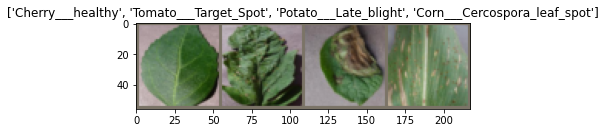

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

* augmentation이 잘 된것을 확인할 수 있음

레이어 반정도만 Freeze

In [ ]:
resnet = models.resnet50(pretrained=True).cuda()
num_ftrs = resnet.fc.in_features  #fully connected에 입력되는 수

#맨 마지막 레이어 바꿔버리기
resnet.fc = nn.Linear(num_ftrs, 33)  
resnet = resnet.to(device)

criterion = nn.CrossEntropyLoss() 

optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, resnet.parameters()), lr=0.001)

# 7 에폭마다 0.1씩 학습율 감소  => 에폭에 따라 adaptive하게
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
ct = 0
for child in resnet.children():  
  ct+= 1   #ct번째 레이어
  if ct < 6:  #freeze layer1-3  out of 10
      for param in child.parameters():
          param.requires_grad = False

In [ ]:
#모델 출력해보기
list(resnet.modules()) # to inspect the modules of your model
my_model = nn.Sequential(*list(resnet.modules())[:-1]) # strips off last linear layer
print(my_model)

In [ ]:
i=0
for param in resnet.parameters():
    print(i, param.requires_grad)
    i+=1

0 False
1 False
2 False
3 False
4 False
5 False
6 False
7 False
8 False
9 False
10 False
11 False
12 False
13 False
14 False
15 False
16 False
17 False
18 False
19 False
20 False
21 False
22 False
23 False
24 False
25 False
26 False
27 False
28 False
29 False
30 False
31 False
32 False
33 True
34 True
35 True
36 True
37 True
38 True
39 True
40 True
41 True
42 True
43 True
44 True
45 True
46 True
47 True
48 True
49 True
50 True
51 True
52 True
53 True
54 True
55 True
56 True
57 True
58 True
59 True
60 True
61 True
62 True
63 True
64 True
65 True
66 True
67 True
68 True
69 True
70 True
71 True
72 True
73 True
74 True
75 True
76 True
77 True
78 True
79 True
80 True
81 True
82 True
83 True
84 True
85 True
86 True
87 True
88 True
89 True
90 True
91 True
92 True
93 True
94 True
95 True
96 True
97 True
98 True
99 True
100 True
101 True
102 True
103 True
104 True
105 True
106 True
107 True
108 True
109 True
110 True
111 True
112 True
113 True
114 True
115 True
116 True
117 True
118 True
119 Tr

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())  
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # 각 에폭(epoch)은 학습 단계와 검증 단계를 갖습니다.
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # train phase에서는 모델을 학습 모드로 설정
            else:
                model.eval()   # val phase에서는 모델을 평가 모드로 설정

            running_loss = 0.0
            running_corrects = 0

            # 데이터를 반복
            for inputs, labels in dataloaders[phase]:  
                inputs = inputs.to(device)
                labels = labels.to(device)

                # 매개변수 경사도를 0으로 설정
                optimizer.zero_grad()

                # 순전파
                # train phase에서만 연산 기록을 추적
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # 학습 단계인 경우 역전파 + 최적화
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # 통계
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]  

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # val 단계에서 acc가 더 모델을 깊은 복사(deep copy)함
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # 가장 나은 모델 가중치를 불러옴
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
model_resnet50 = train_model(resnet, criterion, optimizer_ft, exp_lr_scheduler,num_epochs=30) 

Epoch 0/29
----------
train Loss: 3.5821 Acc: 0.0172
val Loss: 3.7180 Acc: 0.0283

Epoch 1/29
----------
train Loss: 3.5772 Acc: 0.0217
val Loss: 3.8063 Acc: 0.0417

Epoch 2/29
----------
train Loss: 3.5767 Acc: 0.0167
val Loss: 3.6945 Acc: 0.0268

Epoch 3/29
----------
train Loss: 3.5783 Acc: 0.0192
val Loss: 3.7367 Acc: 0.0283

Epoch 4/29
----------
train Loss: 3.5819 Acc: 0.0167
val Loss: 3.7248 Acc: 0.0283

Epoch 5/29
----------
train Loss: 3.5785 Acc: 0.0197
val Loss: 3.8340 Acc: 0.0328

Epoch 6/29
----------
train Loss: 3.5790 Acc: 0.0192
val Loss: 3.6409 Acc: 0.0283

Epoch 7/29
----------
train Loss: 3.5754 Acc: 0.0182
val Loss: 3.7408 Acc: 0.0238

Epoch 8/29
----------
train Loss: 3.5785 Acc: 0.0172
val Loss: 3.7596 Acc: 0.0283

Epoch 9/29
----------
train Loss: 3.5822 Acc: 0.0192
val Loss: 3.7481 Acc: 0.0283

Epoch 10/29
----------
train Loss: 3.5771 Acc: 0.0226
val Loss: 3.7961 Acc: 0.0387

Epoch 11/29
----------
train Loss: 3.5766 Acc: 0.0192
val Loss: 3.8158 Acc: 0.0283

Ep

KeyboardInterrupt: ignored

In [ ]:
torch.save(model_resnet50, 'resnet50.pt')  

## **성능 평가**

###Prediction

In [ ]:
#imbalanced raw data로 훈련된 모델 prediction
baseline_imb=torch.load('imbalanced_baseline.pt')
baseline_imb.eval()
test_loss, test_accuracy = evaluate(baseline_imb, test_loader)
print('test acc:  ', test_accuracy)

In [ ]:
#balanced data로 훈련된 모델 prediction
baseline_bal=torch.load('balanced_baseline.pt')
baseline_bal.eval()
test_loss, test_accuracy = evaluate(baseline_bal, test_loader)
print('test acc:  ', test_accuracy)

In [ ]:
#resnet50 모델 prediction
resnet50=torch.load('resnet50.pt')
resnet50.eval()
test_loss, test_accuracy = evaluate(resnet50, test_loader)
print('test acc:  ', test_accuracy)